# Pedestrian Crash - Classification

Binary classification on the model with boundary 800.

## Import the necessary modules

In [1]:
from pathlib import Path
import sys

sys.path.append("C:\\Users\\geork\\projects\\AIThesis\\src")
sys.path.append("C:\\Users\\geork\\projects\\AIThesis\\src\\src")

from src.dataset_reader import DatasetReaderCSV
from src.utilities import to_scrollable_table
from src.plot import plot_car_attributes, plot_pedestrian_attributes, plot_hic_value, plot_validation_acc_values
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Read the dataset

I am reading the dataset from a file.
I've previously exported the dataset using another script.

In [2]:
path = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_1\\crash_simulation_classification.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Position"], errors="ignore")

In [3]:
to_remove_features = ["Id", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max"]
# Remove the unwanted columns
df = df.drop(columns=to_remove_features)

## Dataset Insights

### Dataset Head

In [4]:
# Print 10 random rows from the DataFrame
df.sample(n=10)

,CarProfile,Velocity,Translation,Rotation,HIC15_max
450,MPV,40,0,270,40585.092
51,FCR,100,400,180,125.578
69,FCR,20,-200,330,443.465
584,MPV,80,200,30,25588.107
798,RDS,60,-400,270,4798.633
32,FCR,100,0,30,687.594
1179,SUV,80,200,180,496.474
994,SUV,20,0,60,1419.981
275,FCR,80,0,90,6489.363
176,FCR,40,400,30,473.506


### Dataset description

In [5]:
print(df.describe())

          Velocity  Translation     Rotation      HIC15_max
count  1200.000000  1200.000000  1200.000000    1200.000000
mean     60.000000     0.000000   165.000000   10594.607520
std      28.296064   282.960637   103.604754   28156.535615
min      20.000000  -400.000000     0.000000       0.000000
25%      40.000000  -200.000000    82.500000     444.451250
50%      60.000000     0.000000   165.000000    1826.896500
75%      80.000000   200.000000   247.500000    7791.743000
max     100.000000   400.000000   330.000000  277304.682000


### Dataset table

In [6]:
to_scrollable_table(df)

CarProfile,Velocity,Translation,Rotation,HIC15_max
FCR,100,-200,0,86.843
FCR,100,-200,120,2361.697
FCR,100,-200,150,573.455
FCR,100,-200,180,84.702
FCR,100,-200,210,592.965
FCR,100,-200,240,1235.194
FCR,100,-200,270,6257.955
FCR,100,-200,300,4974.677
FCR,100,-200,30,775.362
FCR,100,-200,330,440.203


### Car profile attributes

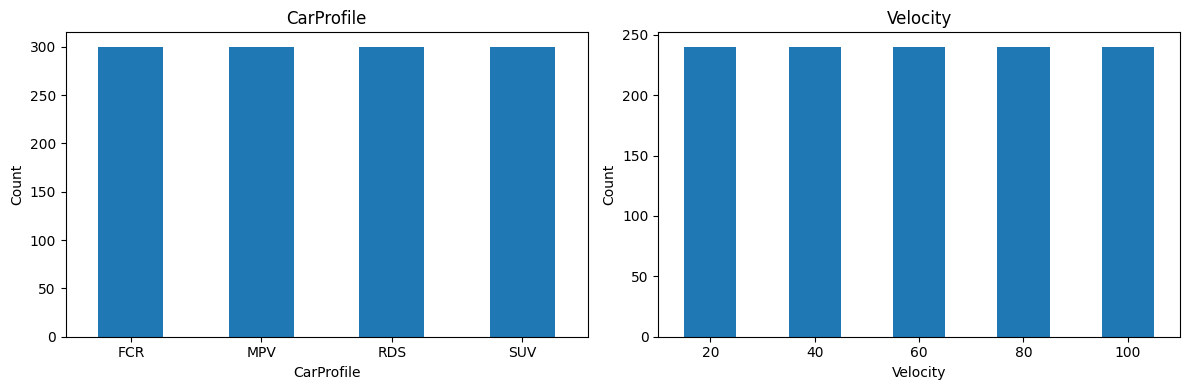

In [7]:
plot_car_attributes(df)

### Pedestrian attributes

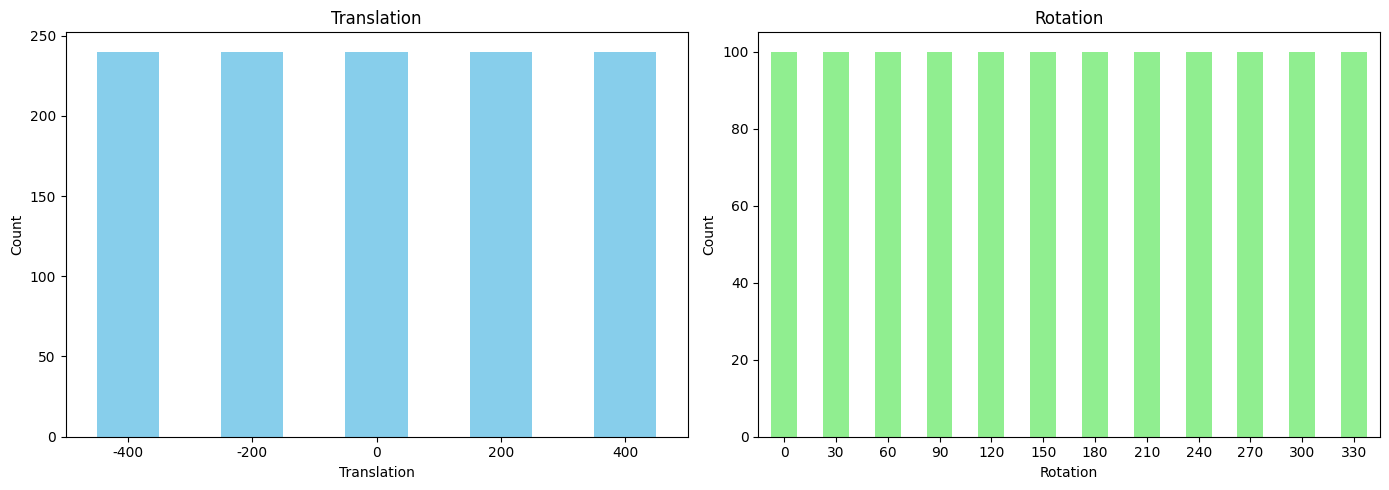

In [8]:
plot_pedestrian_attributes(df)

### Target attributes

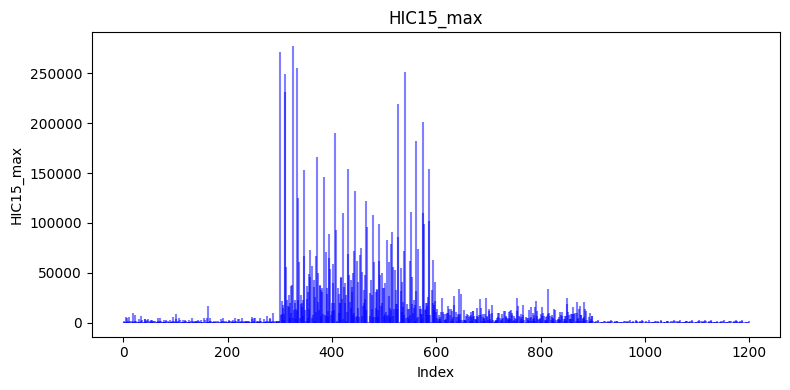

In [9]:
plot_hic_value(df, "HIC15_max")


### Categorical conversion in CarProfile column

In [10]:
df["CarProfile"] = pd.Categorical(df["CarProfile"]).codes

## Binary classification (<800) HIC15_max

### Setup threshold

In [11]:
THRESHOLD = 800

### Create HIC15 binary

In [12]:
# Create a new target column for the classification
df_bin = df.copy()
df_bin["HIC15_over_800"] = (df["HIC15_max"] > 800).astype(int)
df_bin = df_bin.drop(columns=["HIC15_max"])

### Plot HIC15 thresholds

Entries over the threshold: 791
Entries under the threshold: 409


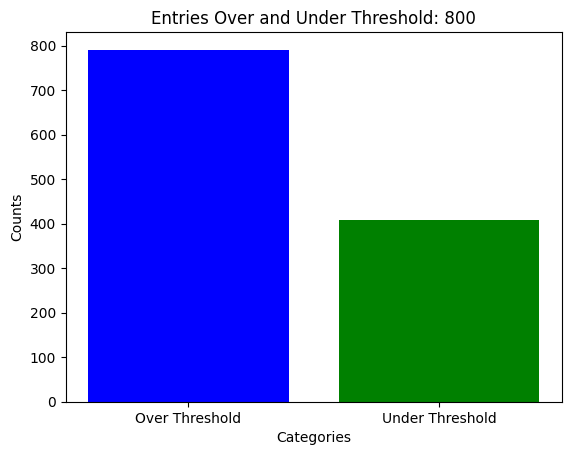

In [13]:
over_thres  = (df_bin["HIC15_over_800"] == True).sum()
under_thres = (df_bin["HIC15_over_800"] == False).sum()

print("Entries over the threshold:", over_thres)
print("Entries under the threshold:", under_thres)

# Data for the bar chart
categories = ['Over Threshold', 'Under Threshold']
counts = [over_thres, under_thres]

# Create the bar chart
plt.bar(categories, counts, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Entries Over and Under Threshold: 800')

# Show the plot
plt.show()

### Separate train/test sets

In [14]:
# Split the data into features and target
X = df_bin.drop(columns=["HIC15_over_800"])
y = df_bin["HIC15_over_800"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Apply normalization to the dataset

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training #1

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

# Step 7: Build and train the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

filepath = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_1\\5_1_1\\model_5_1_1.keras")

# Define a callback to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                              save_best_only=True, mode='min', verbose=1)

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model with the checkpoint callback
history = model.fit(X_train, y_train, epochs=200, batch_size=10, 
                    validation_data=(X_test, y_test), 
                    callbacks=[
                        checkpoint, 
                        early_stopping
                        ])

# Load the best model
best_model = load_model(filepath)

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Best Test Accuracy: {accuracy * 100:.2f}%')

Epoch 1/200


c:\Users\geork\projects\AIThesis\src\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6097 - loss: 1.1287
Epoch 1: val_loss improved from inf to 0.90601, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_1\5_1_1\model_5_1_1.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6143 - loss: 1.1175 - val_accuracy: 0.7083 - val_loss: 0.9060
Epoch 2/200
82/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6698 - loss: 0.9050
Epoch 2: val_loss improved from 0.90601 to 0.78322, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_1\5_1_1\model_5_1_1.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6684 - loss: 0.9004 - val_accuracy: 0.7083 - val_loss: 0.7832
Epoch 3/200
76/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6718 - loss: 0.7939
Epoch 3: val_loss improved from 0.78322 to 0.71787, saving model to C:\Users\geork\projects\AIThesis\src\analysis\ThesisChapters\5_1\5_1_1\model_5_1_1.keras
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6720 - 

In [39]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301 (28.52 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,868 (19.02 KB)

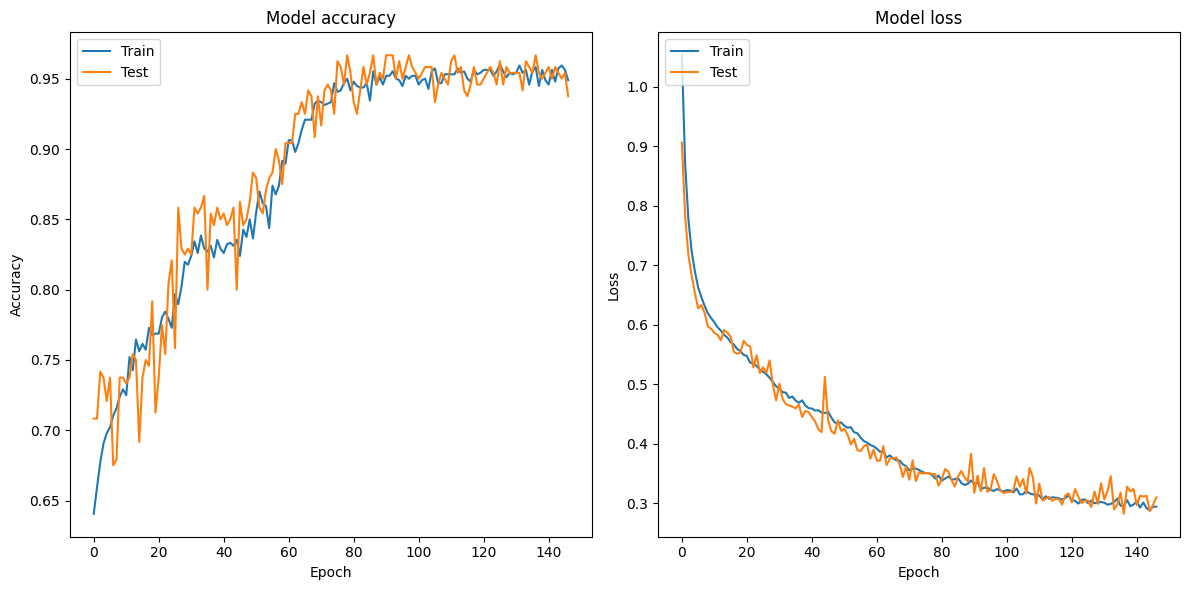

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


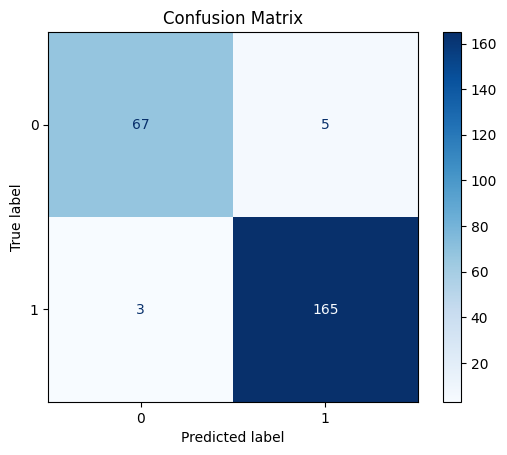

In [40]:
plot_validation_acc_values(history)

# Predict the classes of the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()